# Isochrones SEB photometric model 

In [1]:
import astropy.table as astab
from isochrones import BinaryStarModel,get_ichrone
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from zero_point import zpt
from corner import corner
import arviz as az
import helper_functions as hf
from optparse import OptionParser
import itertools
import os

DD = hf.load_system_specific_directory()

import sys
what_machine_am_i_on = sys.platform

if what_machine_am_i_on == 'darwin':
    hq_joker_edr3_apogee_tess_df = astab.Table.read(DD+"dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits").to_pandas()

if what_machine_am_i_on == 'linux' or what_machine_am_i_on == 'linux2':
    hq_joker_edr3_apogee_tess_df = astab.Table.read(DD+"unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits").to_pandas()



Holoviews not imported. Some visualizations will not be available.


running on macOS
running on macOS


### Helper functions

In [36]:

# hq_joker_edr3_apogee_tess_df = astab.Table.read(DD+"unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits").to_pandas()

zpt.load_tables()

def get_edr3_dr2_xmatch(data):
    """ Main code format taken from Auriga Neural Net github page. Takes a
    dataframe of Gaia DR2 source_ids and cross-matches them with the cross
    matching done by the Gaia collaboration between the DR2 catalog and the
    EDR3 catalog.

    Parameters
    ----------
        data : pandas dataframe
            Stars for which you want to download data for. Must include the
            columns 'Cluster', 'source_id', and 'tag'
    Returns
    -------
        dat : pandas dataframe
            Results from Gaia ADQL query converted to pandas dataframe.
    """
    from astroquery.gaia import Gaia 
    from astropy.table import Table

    Gaia.login(user='kjaehnig',
                password='Legacyofash117!', verbose=True)
    table = Table([data['GAIAEDR3_SOURCE_ID'], data['ID']],# data['bss_flag']],
                names=['source_id','tic'])
    # orig_id = str(datrow['source_id'].squeeze())
    # print(orig_id)
    # table = Table([datrow['source_id']],names=['orig_id'])
    res = Gaia.launch_job_async(query="select tbl.tic, \
            gedr3.source_id, gedr3.parallax, gedr3.parallax_error, gedr3.phot_g_mean_mag, \
            gedr3.phot_bp_mean_mag, gedr3.phot_rp_mean_mag, gedr3.nu_eff_used_in_astrometry, \
            gedr3.phot_g_mean_flux, gedr3.phot_g_mean_flux_error, \
            gedr3.phot_bp_mean_flux, gedr3.phot_bp_mean_flux_error, \
            gedr3.phot_rp_mean_flux, gedr3.phot_rp_mean_flux_error, \
            gedr3.pseudocolour, gedr3.ecl_lat, gedr3.astrometric_params_solved, \
            dr3_dist.r_med_geo, dr3_dist.r_lo_geo, dr3_dist.r_hi_geo, \
            dr3_dist.r_med_photogeo, dr3_dist.r_lo_photogeo, dr3_dist.r_hi_photogeo \
            from gaiaedr3.gaia_source as gedr3 \
            inner join TAP_UPLOAD.mytbl as tbl \
                on gedr3.source_id = tbl.source_id \
            inner join external.gaiaedr3_distance as dr3_dist \
                on gedr3.source_id = dr3_dist.source_id",
            upload_resource=table, upload_table_name='mytbl')
    dat = res.get_results().to_pandas() 
    # dat['Cluster'] = dat.Cluster.str.decode("UTF-8")
    return dat




def get_2mass_mag_uncertainties(data):
    from astroquery.gaia import Gaia
    table=astab.Table([data['source_id']],names=['source_id'])
    j = Gaia.launch_job_async(query="select g.source_id,tm.j_msigcom as ej,tm.h_msigcom as eh,tm.ks_msigcom as ek \
        FROM gaiadr2.gaia_source AS g \
        inner join TAP_UPLOAD.table_test AS tc \
        ON g.source_id = tc.source_id \
        LEFT OUTER JOIN gaiadr2.tmass_best_neighbour AS xmatch \
        ON g.source_id = xmatch.source_id \
        LEFT OUTER JOIN gaiadr1.tmass_original_valid AS tm \
        ON tm.tmass_oid = xmatch.tmass_oid", upload_resource=table, upload_table_name="table_test")
    d = j.get_results().to_pandas()
    return d


def generate_params_for_multinest(ticnum, return_edr3=False):
    
    ticrow = hq_joker_edr3_apogee_tess_df.loc[hq_joker_edr3_apogee_tess_df['ID'] == ticnum]
    print(ticrow.columns.values)
    tmass_errs = get_2mass_mag_uncertainties(ticrow)
    if tmass_errs.shape[0] > 0:
        assert tmass_errs.source_id.squeeze() == ticrow['source_id'].squeeze()
        eh,ej,ek = tmass_errs.eh.squeeze(), tmass_errs.ej.squeeze(), tmass_errs.ek.squeeze()
    if tmass_errs.shape[0] == 0:
        print("no tmass errors available.")
        eh,ej,ek = 0.02,0.02,0.02


    g = ticrow.phot_g_mean_mag.squeeze()
    bp = ticrow.phot_bp_mean_mag.squeeze()
    rp = ticrow.phot_rp_mean_mag.squeeze()
    eg =  (-2.5*np.log10(ticrow.phot_g_mean_flux.squeeze() -ticrow.phot_g_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_g_mean_flux.squeeze() +ticrow.phot_g_mean_flux_error.squeeze())) / 2.
    ebp = (-2.5*np.log10(ticrow.phot_bp_mean_flux.squeeze()-ticrow.phot_bp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_bp_mean_flux.squeeze()+ticrow.phot_bp_mean_flux_error.squeeze())) / 2.
    erp = (-2.5*np.log10(ticrow.phot_rp_mean_flux.squeeze()-ticrow.phot_rp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_rp_mean_flux.squeeze()+ticrow.phot_rp_mean_flux_error.squeeze())) / 2.
#     print(eg, ebp, erp)

    edr3_zpt = get_edr3_dr2_xmatch(ticrow)
    zpt_corr = zpt.get_zpt(edr3_zpt["phot_g_mean_mag"], edr3_zpt["nu_eff_used_in_astrometry"],
                   edr3_zpt["pseudocolour"],edr3_zpt["ecl_lat"],
                   edr3_zpt["astrometric_params_solved"],
                   _warnings=False)
    print(edr3_zpt)
    if len(zpt_corr) > 0:
        print("applying zpt correction")
        plx_corr = edr3_zpt.parallax.squeeze()  - zpt_corr[0]
    else:
        plx_corr = edr3_zpt.parallax.squeeze()

    eg3 = edr3_zpt.phot_g_mean_mag.squeeze()
    ebp3 = edr3_zpt.phot_bp_mean_mag.squeeze()
    erp3 = edr3_zpt.phot_rp_mean_mag.squeeze()
    eg3e =  (-2.5*np.log10(edr3_zpt.phot_g_mean_flux.squeeze() -edr3_zpt.phot_g_mean_flux_error.squeeze()) 
          + 2.5*np.log10(edr3_zpt.phot_g_mean_flux.squeeze() +edr3_zpt.phot_g_mean_flux_error.squeeze())) / 2.
    ebp3e = (-2.5*np.log10(edr3_zpt.phot_bp_mean_flux.squeeze()-edr3_zpt.phot_bp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(edr3_zpt.phot_bp_mean_flux.squeeze()+edr3_zpt.phot_bp_mean_flux_error.squeeze())) / 2.
    erp3e = (-2.5*np.log10(edr3_zpt.phot_rp_mean_flux.squeeze()-edr3_zpt.phot_rp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(edr3_zpt.phot_rp_mean_flux.squeeze()+edr3_zpt.phot_rp_mean_flux_error.squeeze())) / 2.

    params = {
#         'Teff':(ticrow.TEFF.squeeze(),ticrow.TEFF_ERR.squeeze()),
#         'logg':(ticrow.LOGG.squeeze(),ticrow.LOGG_ERR.squeeze()),
#         'feh':(ticrow.FE_H.squeeze(), ticrow.FE_H_ERR.squeeze()),
        'H':(ticrow.H.squeeze(), eh),
        'J':(ticrow.J.squeeze(), ej),
        'K':(ticrow.K.squeeze(), ek),
        'BP':(bp, ebp),
        'RP':(rp, erp),
        'G':(g, eg),
        'eBP3':(ebp3, ebp3e),
        'eRP3':(erp3, erp3e),
        'eG3':(eg3, eg3e),
        # 'parallax':(plx_corr , edr3_zpt.parallax_error.squeeze()),
    }

    if return_edr3:   
        return (params, edr3_zpt)
    else:
        return params


def add_tess_mag_to_params_dict(params):
    import ticgen

    mag_dict = {'Jmag':params['J'][0],
                'Hmag':params['H'][0],
                'Ksmag':params['K'][0],
                'Gmag':params['G'][0],
               'integration':2}

    mag_combos = list(itertools.combinations(list(mag_dict.keys())[:-1],2))

    mag_list = []
    for combo in mag_combos:
        mag_dict_samp = {
            combo[0]: mag_dict[combo[0]],
            combo[1]: mag_dict[combo[1]],
            'integration': 2.0
        }
        try:
            mag, _ = ticgen.calc_star(mag_dict_samp)
            mag_list.append(mag)
        except:
            continue

    print(f"there are {len(mag_list)} different mag values")
    print(np.std(mag_list))
    params['TESS'] = (np.median(mag_list), 0.05)

    return params


def calculate_only_tmag_w_G_J(params):
    g,ge = params['G']
    j,je = params['J']

    g_j = g - j
    g_j_e = np.sqrt(je**2. + ge**2.)

    T = (g + 0.00106 * g_j**3. + 0.01278 * g_j**2. - 0.46022 * g_j + 0.0211)

    t2 = abs( (0.00106 * g_j**3. * 3 * g_j_e) / g_j)

    t3 = abs( (0.01278 * g_j**2. * 2 * g_j_e) / g_j)

    t4 = abs( (0.46022 * g_j * 1 * g_j_e) / g_j)

    Te = np.sqrt( 0.015**2. + ge**2. + t2**2. + t3**2. + t4**2. )

    print(f"tmag, err : {T}, {Te}")

    return (T, Te)


def generate_params_for_interp(ticnum):
    
    ticrow = hq_joker_edr3_apogee_tess_df.loc[hq_joker_edr3_apogee_tess_df['ID'] == ticnum]
    
    tmass_errs = get_2mass_mag_uncertainties(ticrow)
    if tmass_errs.shape[0] > 0:
        assert tmass_errs.source_id.squeeze() == ticrow['source_id'].squeeze()
        eh,ej,ek = tmass_errs.eh.squeeze(), tmass_errs.ej.squeeze(), tmass_errs.ek.squeeze()
    if tmass_errs.shape[0] == 0:
        eh,ej,ek = 0.02,0.02,0.02


    g = ticrow.phot_g_mean_mag.squeeze()
    bp = ticrow.phot_bp_mean_mag.squeeze()
    rp = ticrow.phot_rp_mean_mag.squeeze()
    eg = (-2.5*np.log10(ticrow.phot_g_mean_flux.squeeze()-ticrow.phot_g_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_g_mean_flux.squeeze()+ticrow.phot_g_mean_flux_error.squeeze())) / 2.
    ebp = (-2.5*np.log10(ticrow.phot_bp_mean_flux.squeeze()-ticrow.phot_bp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_bp_mean_flux.squeeze()+ticrow.phot_bp_mean_flux_error.squeeze())) / 2.
    erp = (-2.5*np.log10(ticrow.phot_rp_mean_flux.squeeze()-ticrow.phot_rp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_rp_mean_flux.squeeze()+ticrow.phot_rp_mean_flux_error.squeeze())) / 2.
#     print(eg, ebp, erp)

    params = {
        'Teff':(ticrow.TEFF.squeeze(),ticrow.TEFF_ERR.squeeze()),
        'logg':(ticrow.LOGG.squeeze(),ticrow.LOGG_ERR.squeeze()),
        'feh':(ticrow.FE_H.squeeze(), ticrow.FE_H_ERR.squeeze()),
        'H':(ticrow.H.squeeze(), eh),
        'J':(ticrow.J.squeeze(), ej),
        'K':(ticrow.K.squeeze(), ek),
        'BP':(bp, ebp),
        'RP':(rp, erp),
        'G':(g, eg),
        # 'parallax':(ticrow.parallax.squeeze(), ticrow.parallax_error.squeeze())
    }
    
    return params


def get_best_age_eep_mass_bounds(TICNUM, noPMS=True):

    interp_params = generate_params_for_interp(TICNUM)
    from isochrones.mist import MISTEvolutionTrackGrid
    track_grid = MISTEvolutionTrackGrid()
    if noPMS:
        print("eep range 202-1700 (no PMS stars)")
        eep_range = np.arange(202, 1700, 0.25)
    else:
        print('eep range 1-1700 (incl PMS stars)')
        eep_range = np.arange(1, 1700, 0.25)
    from tqdm import tqdm
    min_logg = interp_params['logg'][0] - 0.5
    max_logg = interp_params['logg'][0] + 0.5
    min_teff = interp_params['Teff'][0] - 500
    max_teff = interp_params['Teff'][0] + 500
    # print(tic_params['feh'])

    valid_ages, valid_eeps, valid_mass = [], [], []
    for masses in tqdm(np.linspace(0.1,50,2000), position=0, leave='None'):
        for eep in eep_range:
            interp_vals = track_grid.interp([interp_params['feh'][0], masses, eep], ['age','Teff','logg'])[0]
            age, teff, logg = interp_vals[0], interp_vals[1], interp_vals[2]
            if np.isfinite([age, teff, logg]).sum() == 3:
                bound1 = teff > min_teff
                bound2 = teff < max_teff
                bound3 = logg > min_logg
                bound4 = logg < max_logg
                if bound1 & bound2 & bound3 & bound4:
                    valid_ages.append(age)
                    valid_eeps.append(eep)
                    valid_mass.append(masses)

    return (valid_ages, valid_eeps, valid_mass)


def initialize_multinest_binary_model(ticnum, TestOnly=False, noPMS=True, add_str=''):
    from isochrones.priors import GaussianPrior
    params, edr3_df = generate_params_for_multinest(ticnum, return_edr3=True)

    other_params = add_tess_mag_to_params_dict(params)

    params['TESS'] = calculate_only_tmag_w_G_J(params)

    print("$"*120)
    print(ticnum, calculate_only_tmag_w_G_J(params), other_params['TESS'])
    print("$"*120)
    # params = add_tess_mag_to_params_dict(params)

    mist = get_ichrone('mist', bands=['J','H','K','eBP3','eRP3','eG3','TESS'])
    
    if TestOnly == False:
        test = ''
    else:
        test = 't'
    binarymodel = BinaryStarModel(mist, **params, name=f'TIC_{ticnum}{test}'+add_str)
    binarymodel.mnest_basename = DD+'ceph'+binarymodel.mnest_basename[1:]
    
    # distance = 1000./params['parallax'][0]
#     feh_bounds = (params['feh'][0]-3*params['feh'][1], params['feh'][0]+3*params['feh'][1])
    # print(feh_bounds)
    # plus_dist = (1000./(params['parallax'][0] + params['parallax'][1]))
    # mins_dist = (1000./(params['parallax'][0] - params['parallax'][1]))
#     print(plus_dist, mins_dist)

    # mdist_diff = distance - min(plus_dist, mins_dist)
    # pdist_diff = max(plus_dist, mins_dist) - distance
    
    # edist_estimate = (mdist_diff + pdist_diff) / 2.
    
    r_lo_pg, r_med_pg, r_hi_pg = edr3_df[['r_lo_photogeo','r_med_photogeo','r_hi_photogeo']].squeeze()

    distance = r_med_pg
    edist = .5 * ((distance - r_lo_pg) + (r_hi_pg - distance))
    
    if noPMS:
        print("setting EEP > 202 (no PMS stars)")
        binarymodel.set_bounds(eep=(202,1700), age=(6,11.))
    else:
        print("setting EEP to [0,1700] (incl PMS stars")
        binarymodel.set_bounds(eep=(1,1700), age=(6,11.))
    binarymodel.set_prior(distance=GaussianPrior(distance, 3*edist, 
                                                 bounds=(distance-3*edist, distance+3*edist)))
#     print(5.*mdist_diff, distance, 5.*pdist_diff)
    return binarymodel


### Collecting photometry into isochrones compatible dict

In [34]:
index=0
n_live_points=2000
test_only=1


tic_systems_of_interest = [
28159019,   # 0
99254945,   # 1
126232983,  # 2
164458426,  # 3
164527723,  # 4
165453878,  # 5
169820068,  # 6
258108067,  # 7
271548206,  # 8
272074664,  # 9
20215452,   # 10
144441148,  # 11
365204192   # 12
]

ticsystem = tic_systems_of_interest[index]

binmod = initialize_multinest_binary_model(ticsystem, TestOnly=test_only, noPMS=False)



['APOGEE_ID' 'n_visits' 'MAP_P' 'MAP_P_err' 'MAP_e' 'MAP_e_err'
 'MAP_omega' 'MAP_omega_err' 'MAP_M0' 'MAP_M0_err' 'MAP_K' 'MAP_K_err'
 'MAP_v0' 'MAP_v0_err' 'MAP_s' 'MAP_s_err' 'MAP_t0_bmjd' 't_ref_bmjd'
 'baseline' 'MAP_ln_likelihood' 'MAP_ln_prior'
 'max_unmarginalized_ln_likelihood' 'max_phase_gap' 'periods_spanned'
 'phase_coverage' 'phase_coverage_per_period' 'unimodal' 'joker_completed'
 'mcmc_completed' 'mcmc_status' 'gelman_rubin_max'
 'constant_ln_likelihood' 'robust_constant_ln_likelihood'
 'robust_constant_mean' 'robust_constant_scatter'
 'robust_constant_success' 'robust_linear_ln_likelihood' 'robust_linear_a'
 'robust_linear_b' 'robust_linear_scatter' 'robust_linear_success'
 'solution_id' 'designation' 'source_id' 'random_index' 'ref_epoch' 'ra'
 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pm' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'ra_dec_corr' 'ra_parallax_corr' 'ra_pmra_corr' 'ra_pmdec_corr'
 'dec_parallax_corr' 'dec_pmra_corr'

INFO:astroquery:Query finished.
INFO:astroquery:Login to gaia TAP server


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Login to gaia TAP server [astroquery.gaia.core]


INFO:astroquery:Login to gaia data server


200 200
[('Date', 'Sat, 04 Feb 2023 20:31:05 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Set-Cookie', 'JSESSIONID=A35605E9D95F375CB9C452F1359F6102; Path=/tap-server; Secure; HttpOnly'), ('Transfer-Encoding', 'chunked'), ('Content-Type', 'text/plain; charset=UTF-8')]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
200 200
[('Date', 'Sat, 04 Feb 2023 20:31:07 GMT'), ('Server', 'Apache/2.4.6 (Red Hat Enterprise Linux) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Content-Type-Options', 'nosniff'), ('Set-Cookie', 'JSESSIONID=410CE0F2D72663094A0A316131400CF3; Path=/data-se

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
        tic            source_id  parallax  parallax_error  phot_g_mean_mag  \
0  28159019  2087219797940775040  1.888264        0.011462        11.639594   

   phot_bp_mean_mag  phot_rp_mean_mag  nu_eff_used_in_astrometry  \
0         11.936312         11.172003                   1.569765   

   phot_g_mean_flux  phot_g_mean_flux_error  ...  phot_rp_mean_flux_error  \
0     416015.100344              132.213882  ...               149.699188   

   pseudocolour    ecl_lat  astrometric_params_solved   r_med_geo    r_lo_geo  \
0           NaN  68.180367                         31  517.708313  514.269775   

     r_hi_geo  r_med_photogeo  r_lo_photogeo  r_hi_photogeo  
0  521.203369      517.012695     513.518127     520.031616  

[1 rows x 23 columns]
applying zpt correction
TESS mag = 11.16, calculated using J/H.
1-sigma scatter in 2 min = 2012 ppm.
TESS mag = 11.13, calculated using J/Ks.
1-sigma scatter in 2 min = 1979 ppm.
TESS mag =

### Bootstrapping grid to shave down isochrones prior bounds (possible source of pymc3 systematics)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
eep range 1-1700 (incl PMS stars)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:03<00:00,  2.55it/s]


Text(0.5, 1.0, 'Mass')

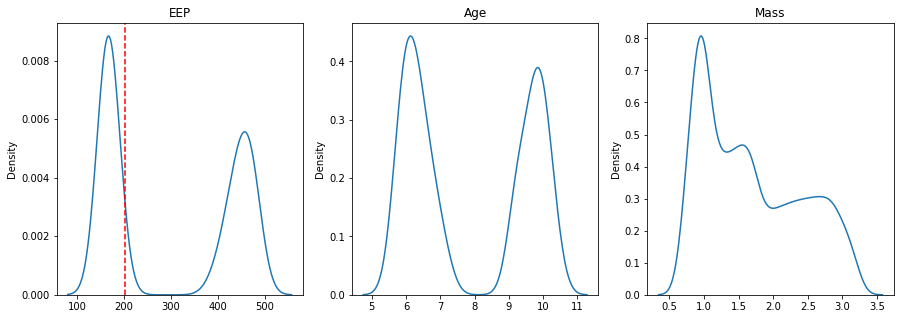

In [35]:
valid_ages,valid_eeps,valid_mass = get_best_age_eep_mass_bounds(ticsystem, noPMS=False)
binmod.set_bounds(eep=(min(valid_eeps), max(valid_eeps)),
              age=(min(valid_ages), max(valid_ages)),
              mass=(max(0.1, min(valid_mass)), min(10, max(valid_mass)))
             )
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))
import seaborn as sns

sns.kdeplot(valid_eeps,ax=ax1)
ax1.axvline(202,ls='--', c='red')
sns.kdeplot(valid_ages, ax=ax2)
sns.kdeplot(valid_mass, ax=ax3)

ax1.set_title('EEP')
ax2.set_title('Age')
ax3.set_title('Mass')

### Run PyMultiNest Isochrones model

In [39]:
print("Starting MultiNest")

binmod.fit(n_live_points=n_live_points, overwrite=True)



Starting MultiNest
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 2000
 dimensionality =    6
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        1.000000
Replacements:                               2050
Total Samples:                              2050
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):    -644.996997 +/-  0.999756
Acceptance Rate:                        0.999049
Replacements:                               2100
Total Samples:                              2102
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):    -645.022046 +/-  0.999762
Acceptance Rate:                        0.997680
Replacements:                 

### Plotting PyMultiNest Corner for distribution checking

Text(0.5, 1.0, 'TIC-28159019')

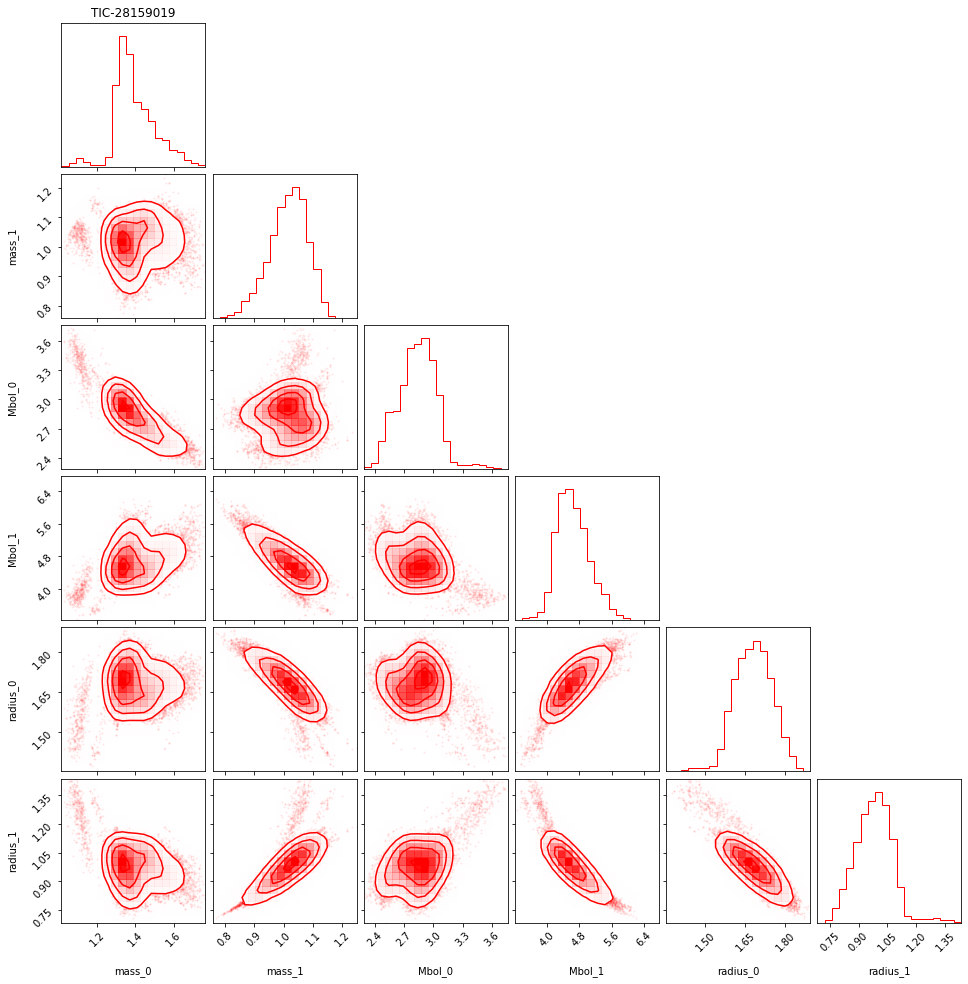

In [40]:
fig = corner(az.from_dict(
    binmod.derived_samples[['mass_0','mass_1','Mbol_0','Mbol_1','radius_0','radius_1']].to_dict('list')),
    smooth=1, color='red')
fig.axes[0].set_title(f'TIC-{ticsystem}')
# plt.savefig(f"{DD}tic_{ticsystem}_multinest_corner.png",dpi=150,bbox_inches='tight')
# plt.close(fig)

# plt.savefig(f"{DD}tic_{ticsystem}_pymc3_priors_corner.png",dpi=150, bbox_inches='tight')
# plt.close(fig)

### plotting pymc3 constructed priors

Text(0.5, 1.0, '28159019')

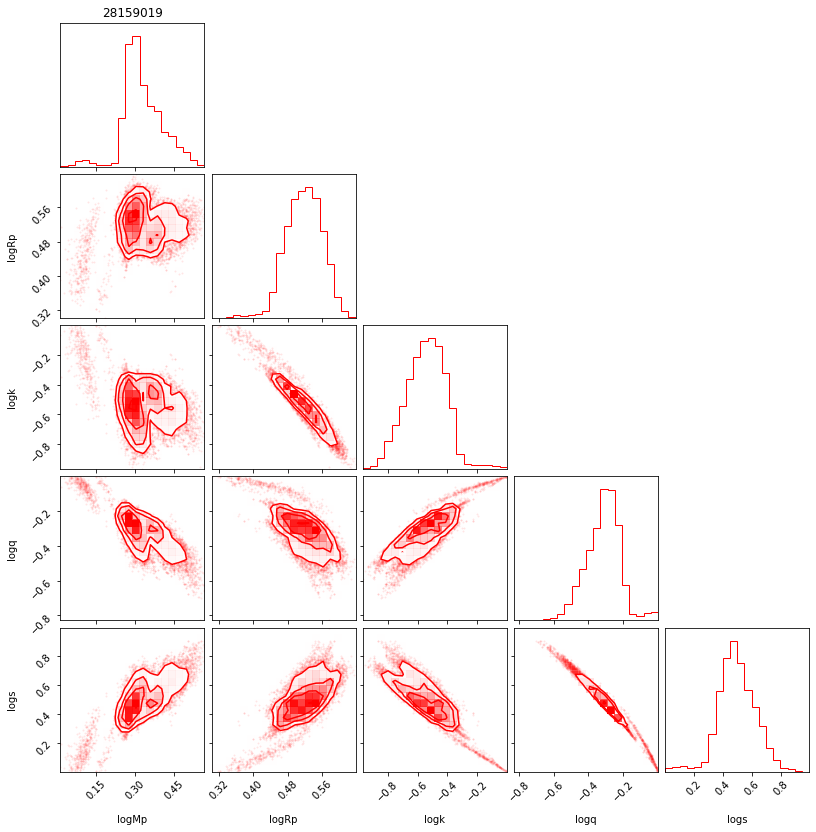

In [41]:
m0,m1,r0,r1,mbol0,mbol1 = binmod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1','Mbol_0','Mbol_1']].values.T
num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])

ms, mp = [m0,m1][num], [m0,m1][denom]

rs, rp = [r0,r1][num], [r0,r1][denom]

mbols,mbolp = [mbol0,mbol1][num], [mbol0,mbol1][denom]

binmod.derived_samples['logMp'] = np.log(mp)
binmod.derived_samples['logRp'] = np.log(rp)
binmod.derived_samples['logk'] = np.log(rs / rp)
binmod.derived_samples['logq'] = np.log(ms / mp)
binmod.derived_samples['logs'] = np.log(mbols / mbolp)

#  binmod.save_hdf(f"{DD}ceph/pymultinest_fits/tic_{ticsystem}_binary_model_obj.hdf",overwrite=True)

fig = corner(az.from_dict(binmod.derived_samples[['logMp','logRp','logk','logq','logs']].to_dict('list')), color='red')
fig.axes[0].set_title(ticsystem) 

### all PyMultiNest physical quantities corner

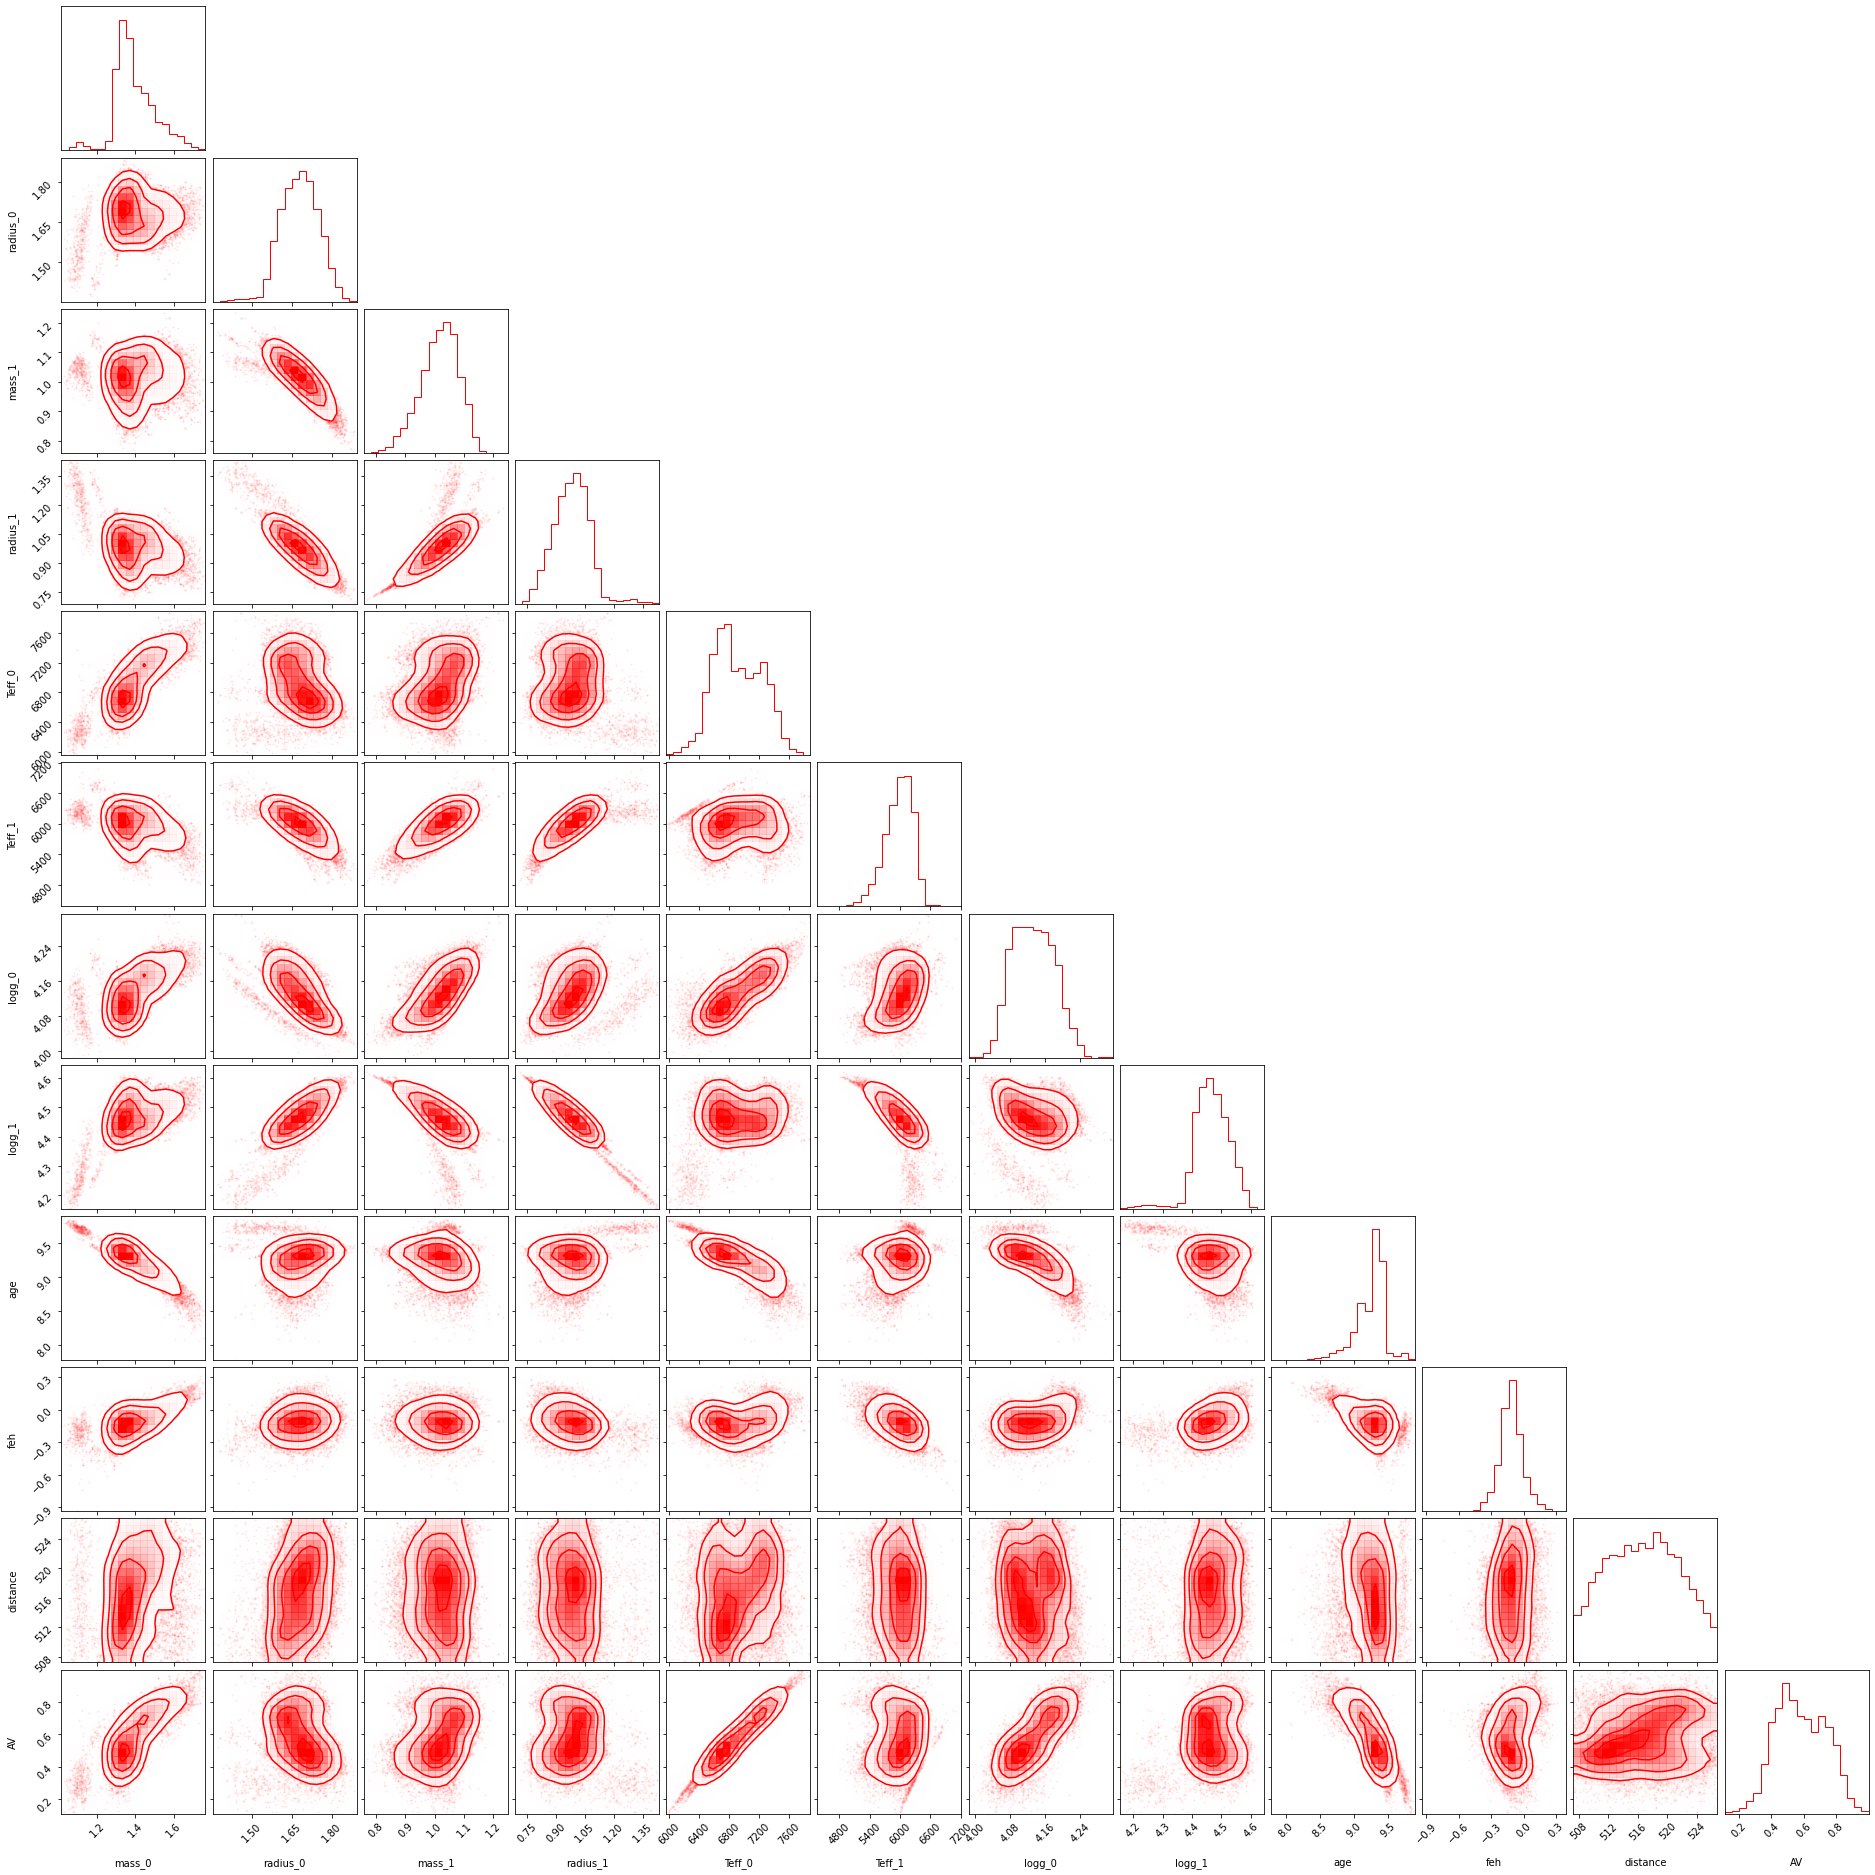

In [42]:
phys_quant = binmod.physical_quantities
fig = corner(az.from_dict(
    binmod.derived_samples[phys_quant].to_dict('list')),
    smooth=1, color='red')

### Now rerun isochrones model without any PMS stars (EEP > 202)

['APOGEE_ID' 'n_visits' 'MAP_P' 'MAP_P_err' 'MAP_e' 'MAP_e_err'
 'MAP_omega' 'MAP_omega_err' 'MAP_M0' 'MAP_M0_err' 'MAP_K' 'MAP_K_err'
 'MAP_v0' 'MAP_v0_err' 'MAP_s' 'MAP_s_err' 'MAP_t0_bmjd' 't_ref_bmjd'
 'baseline' 'MAP_ln_likelihood' 'MAP_ln_prior'
 'max_unmarginalized_ln_likelihood' 'max_phase_gap' 'periods_spanned'
 'phase_coverage' 'phase_coverage_per_period' 'unimodal' 'joker_completed'
 'mcmc_completed' 'mcmc_status' 'gelman_rubin_max'
 'constant_ln_likelihood' 'robust_constant_ln_likelihood'
 'robust_constant_mean' 'robust_constant_scatter'
 'robust_constant_success' 'robust_linear_ln_likelihood' 'robust_linear_a'
 'robust_linear_b' 'robust_linear_scatter' 'robust_linear_success'
 'solution_id' 'designation' 'source_id' 'random_index' 'ref_epoch' 'ra'
 'ra_error' 'dec' 'dec_error' 'parallax' 'parallax_error'
 'parallax_over_error' 'pm' 'pmra' 'pmra_error' 'pmdec' 'pmdec_error'
 'ra_dec_corr' 'ra_parallax_corr' 'ra_pmra_corr' 'ra_pmdec_corr'
 'dec_parallax_corr' 'dec_pmra_corr'

INFO:astroquery:Query finished.
INFO:astroquery:Login to gaia TAP server


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Login to gaia TAP server [astroquery.gaia.core]


INFO:astroquery:Login to gaia data server


200 200
[('Date', 'Sat, 04 Feb 2023 21:56:45 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Set-Cookie', 'JSESSIONID=4F2742577DCCCE48296487AEFD73D7FC; Path=/tap-server; Secure; HttpOnly'), ('Transfer-Encoding', 'chunked'), ('Content-Type', 'text/plain; charset=UTF-8')]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
200 200
[('Date', 'Sat, 04 Feb 2023 21:56:47 GMT'), ('Server', 'Apache/2.4.6 (Red Hat Enterprise Linux) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Content-Type-Options', 'nosniff'), ('Set-Cookie', 'JSESSIONID=9FE037A8BA43294F1C55F275CA643723; Path=/data-se

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
        tic            source_id  parallax  parallax_error  phot_g_mean_mag  \
0  28159019  2087219797940775040  1.888264        0.011462        11.639594   

   phot_bp_mean_mag  phot_rp_mean_mag  nu_eff_used_in_astrometry  \
0         11.936312         11.172003                   1.569765   

   phot_g_mean_flux  phot_g_mean_flux_error  ...  phot_rp_mean_flux_error  \
0     416015.100344              132.213882  ...               149.699188   

   pseudocolour    ecl_lat  astrometric_params_solved   r_med_geo    r_lo_geo  \
0           NaN  68.180367                         31  517.708313  514.269775   

     r_hi_geo  r_med_photogeo  r_lo_photogeo  r_hi_photogeo  
0  521.203369      517.012695     513.518127     520.031616  

[1 rows x 23 columns]
applying zpt correction
TESS mag = 11.16, calculated using J/H.
1-sigma scatter in 2 min = 2012 ppm.
TESS mag = 11.13, calculated using J/Ks.
1-sigma scatter in 2 min = 1979 ppm.
TESS mag =

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
eep range 202-1700 (no PMS stars)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:32<00:00,  2.89it/s]


Text(0.5, 1.0, 'Mass')

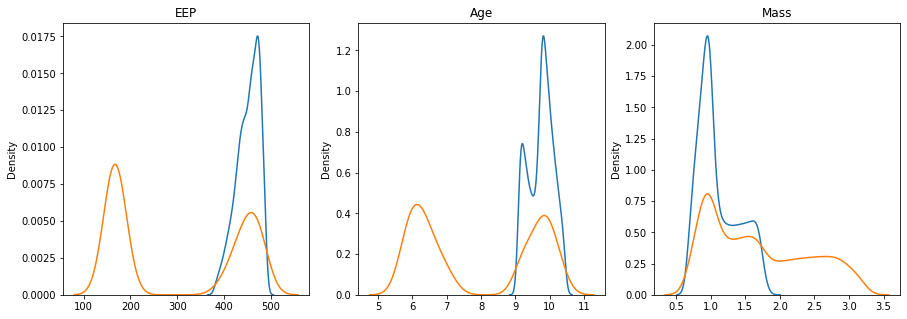

In [43]:
index=0
n_live_points=2000
test_only=1


tic_systems_of_interest = [
28159019,   # 0
99254945,   # 1
126232983,  # 2
164458426,  # 3
164527723,  # 4
165453878,  # 5
169820068,  # 6
258108067,  # 7
271548206,  # 8
272074664,  # 9
20215452,   # 10
144441148,  # 11
365204192   # 12
]

ticsystem = tic_systems_of_interest[index]

binmod2 = initialize_multinest_binary_model(ticsystem, TestOnly=test_only, noPMS=True, add_str='_noPMS')

valid_ages2,valid_eeps2,valid_mass2 = get_best_age_eep_mass_bounds(ticsystem, noPMS=True)
binmod2.set_bounds(eep=(min(valid_eeps2), max(valid_eeps2)),
              age=(min(valid_ages2), max(valid_ages2)),
              mass=(max(0.1, min(valid_mass2)), min(10, max(valid_mass2)))
             )

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,5))
import seaborn as sns

sns.kdeplot(valid_eeps2,ax=ax1)
# ax1.axvline(202,ls='--', c='red')
sns.kdeplot(valid_ages2, ax=ax2)
sns.kdeplot(valid_mass2, ax=ax3)

sns.kdeplot(valid_eeps,ax=ax1)
# ax1.axvline(202,ls='--', c='red')
sns.kdeplot(valid_ages, ax=ax2)
sns.kdeplot(valid_mass, ax=ax3)


ax1.set_title('EEP')
ax2.set_title('Age')
ax3.set_title('Mass')

In [44]:
print("Starting MultiNest")

binmod2.fit(n_live_points=n_live_points, overwrite=True)

Starting MultiNest
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 2000
 dimensionality =    6
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        1.000000
Replacements:                               2050
Total Samples:                              2050
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):    -118.687154 +/-  0.999756
Acceptance Rate:                        0.999049
Replacements:                               2100
Total Samples:                              2102
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):    -118.712204 +/-  0.999762
Acceptance Rate:                        0.997217
Replacements:                 

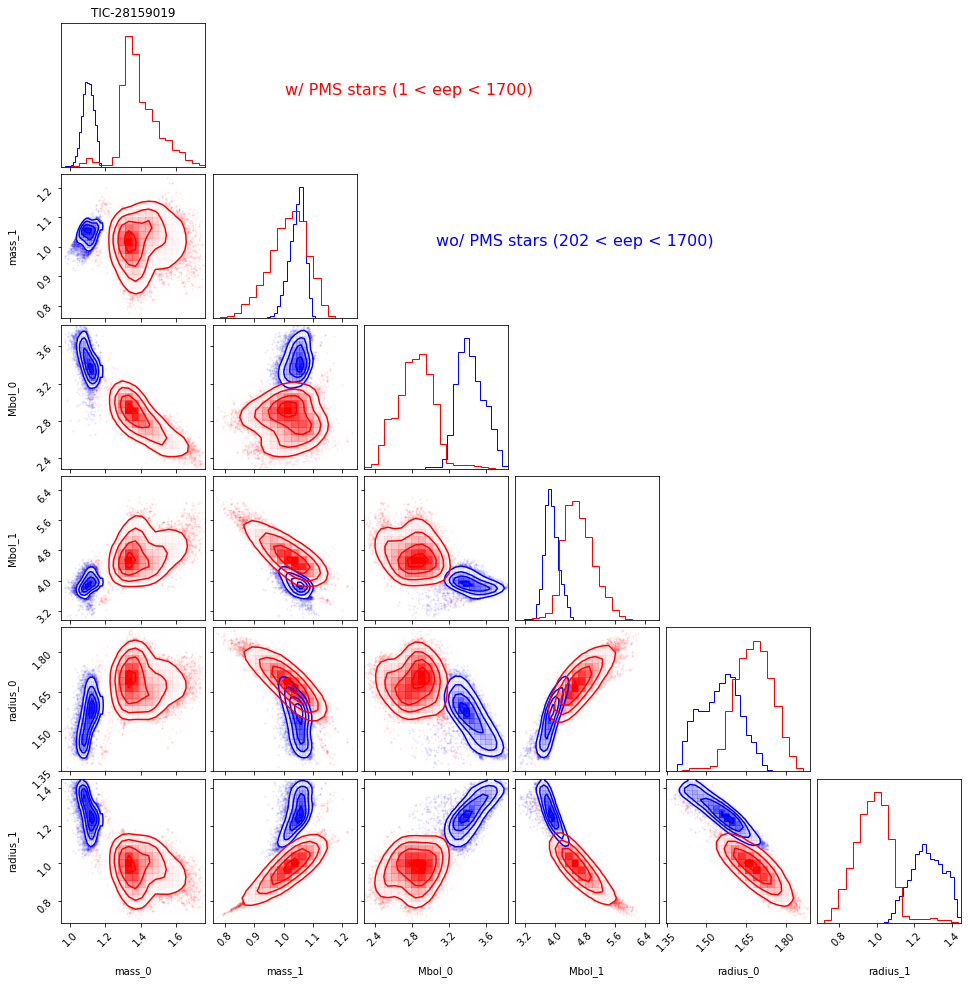

In [61]:
fig = corner(az.from_dict(
    binmod2.derived_samples[['mass_0','mass_1','Mbol_0','Mbol_1','radius_0','radius_1']].to_dict('list')),
    smooth=1., color='blue')
fig.axes[0].set_title(f'TIC-{ticsystem}')
# plt.savefig(f"{DD}tic_{ticsystem}_multinest_corner.png",dpi=150,bbox_inches='tight')
# plt.close(fig)

corner(az.from_dict(
    binmod.derived_samples[['mass_0','mass_1','Mbol_0','Mbol_1','radius_0','radius_1']].to_dict('list')),
    smooth=1, fig=fig, color='red')
fig.axes[1].text(0.5,0.5,'w/ PMS stars (1 < eep < 1700)',color='red',fontsize=16)
fig.axes[8].text(0.5,0.5,'wo/ PMS stars (202 < eep < 1700)', color='blue', fontsize=16)
plt.savefig(f"{DD}tic_{ticsystem}_isochrones_mass_rad_mbol_corner.png",dpi=150, bbox_inches='tight')
# plt.close(fig)

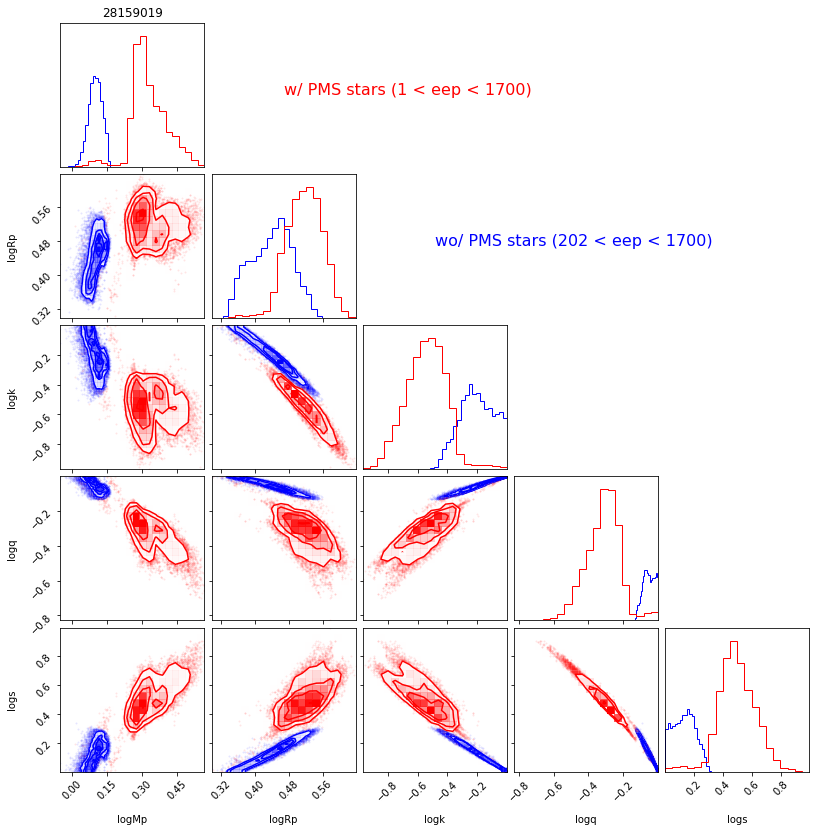

In [62]:

m0,m1,r0,r1,mbol0,mbol1 = binmod2.derived_samples[['mass_0','mass_1','radius_0', 'radius_1','Mbol_0','Mbol_1']].values.T
num, denom = np.argmin([np.median(m0), np.median(m1)]), np.argmax([np.median(m0), np.median(m1)])

ms, mp = [m0,m1][num], [m0,m1][denom]

rs, rp = [r0,r1][num], [r0,r1][denom]

mbols,mbolp = [mbol0,mbol1][num], [mbol0,mbol1][denom]

binmod2.derived_samples['logMp'] = np.log(mp)
binmod2.derived_samples['logRp'] = np.log(rp)
binmod2.derived_samples['logk'] = np.log(rs / rp)
binmod2.derived_samples['logq'] = np.log(ms / mp)
binmod2.derived_samples['logs'] = np.log(mbols / mbolp)

# binmod2.save_hdf(f"{DD}ceph/pymultinest_fits/tic_{ticsystem}_binary_model_obj.hdf",overwrite=True)

fig = corner(az.from_dict(binmod2.derived_samples[['logMp','logRp','logk','logq','logs']].to_dict('list')),color='blue')
corner(az.from_dict(binmod.derived_samples[['logMp','logRp','logk','logq','logs']].to_dict('list')), fig = fig, color='red')
fig.axes[0].set_title(ticsystem) 
fig.axes[1].text(0.5,0.5,'w/ PMS stars (1 < eep < 1700)',color='red',fontsize=16)
fig.axes[7].text(0.5,0.5,'wo/ PMS stars (202 < eep < 1700)', color='blue', fontsize=16)
plt.savefig(f"{DD}tic_{ticsystem}_isochrones_pymc3_priors_corner.png",dpi=150, bbox_inches='tight')


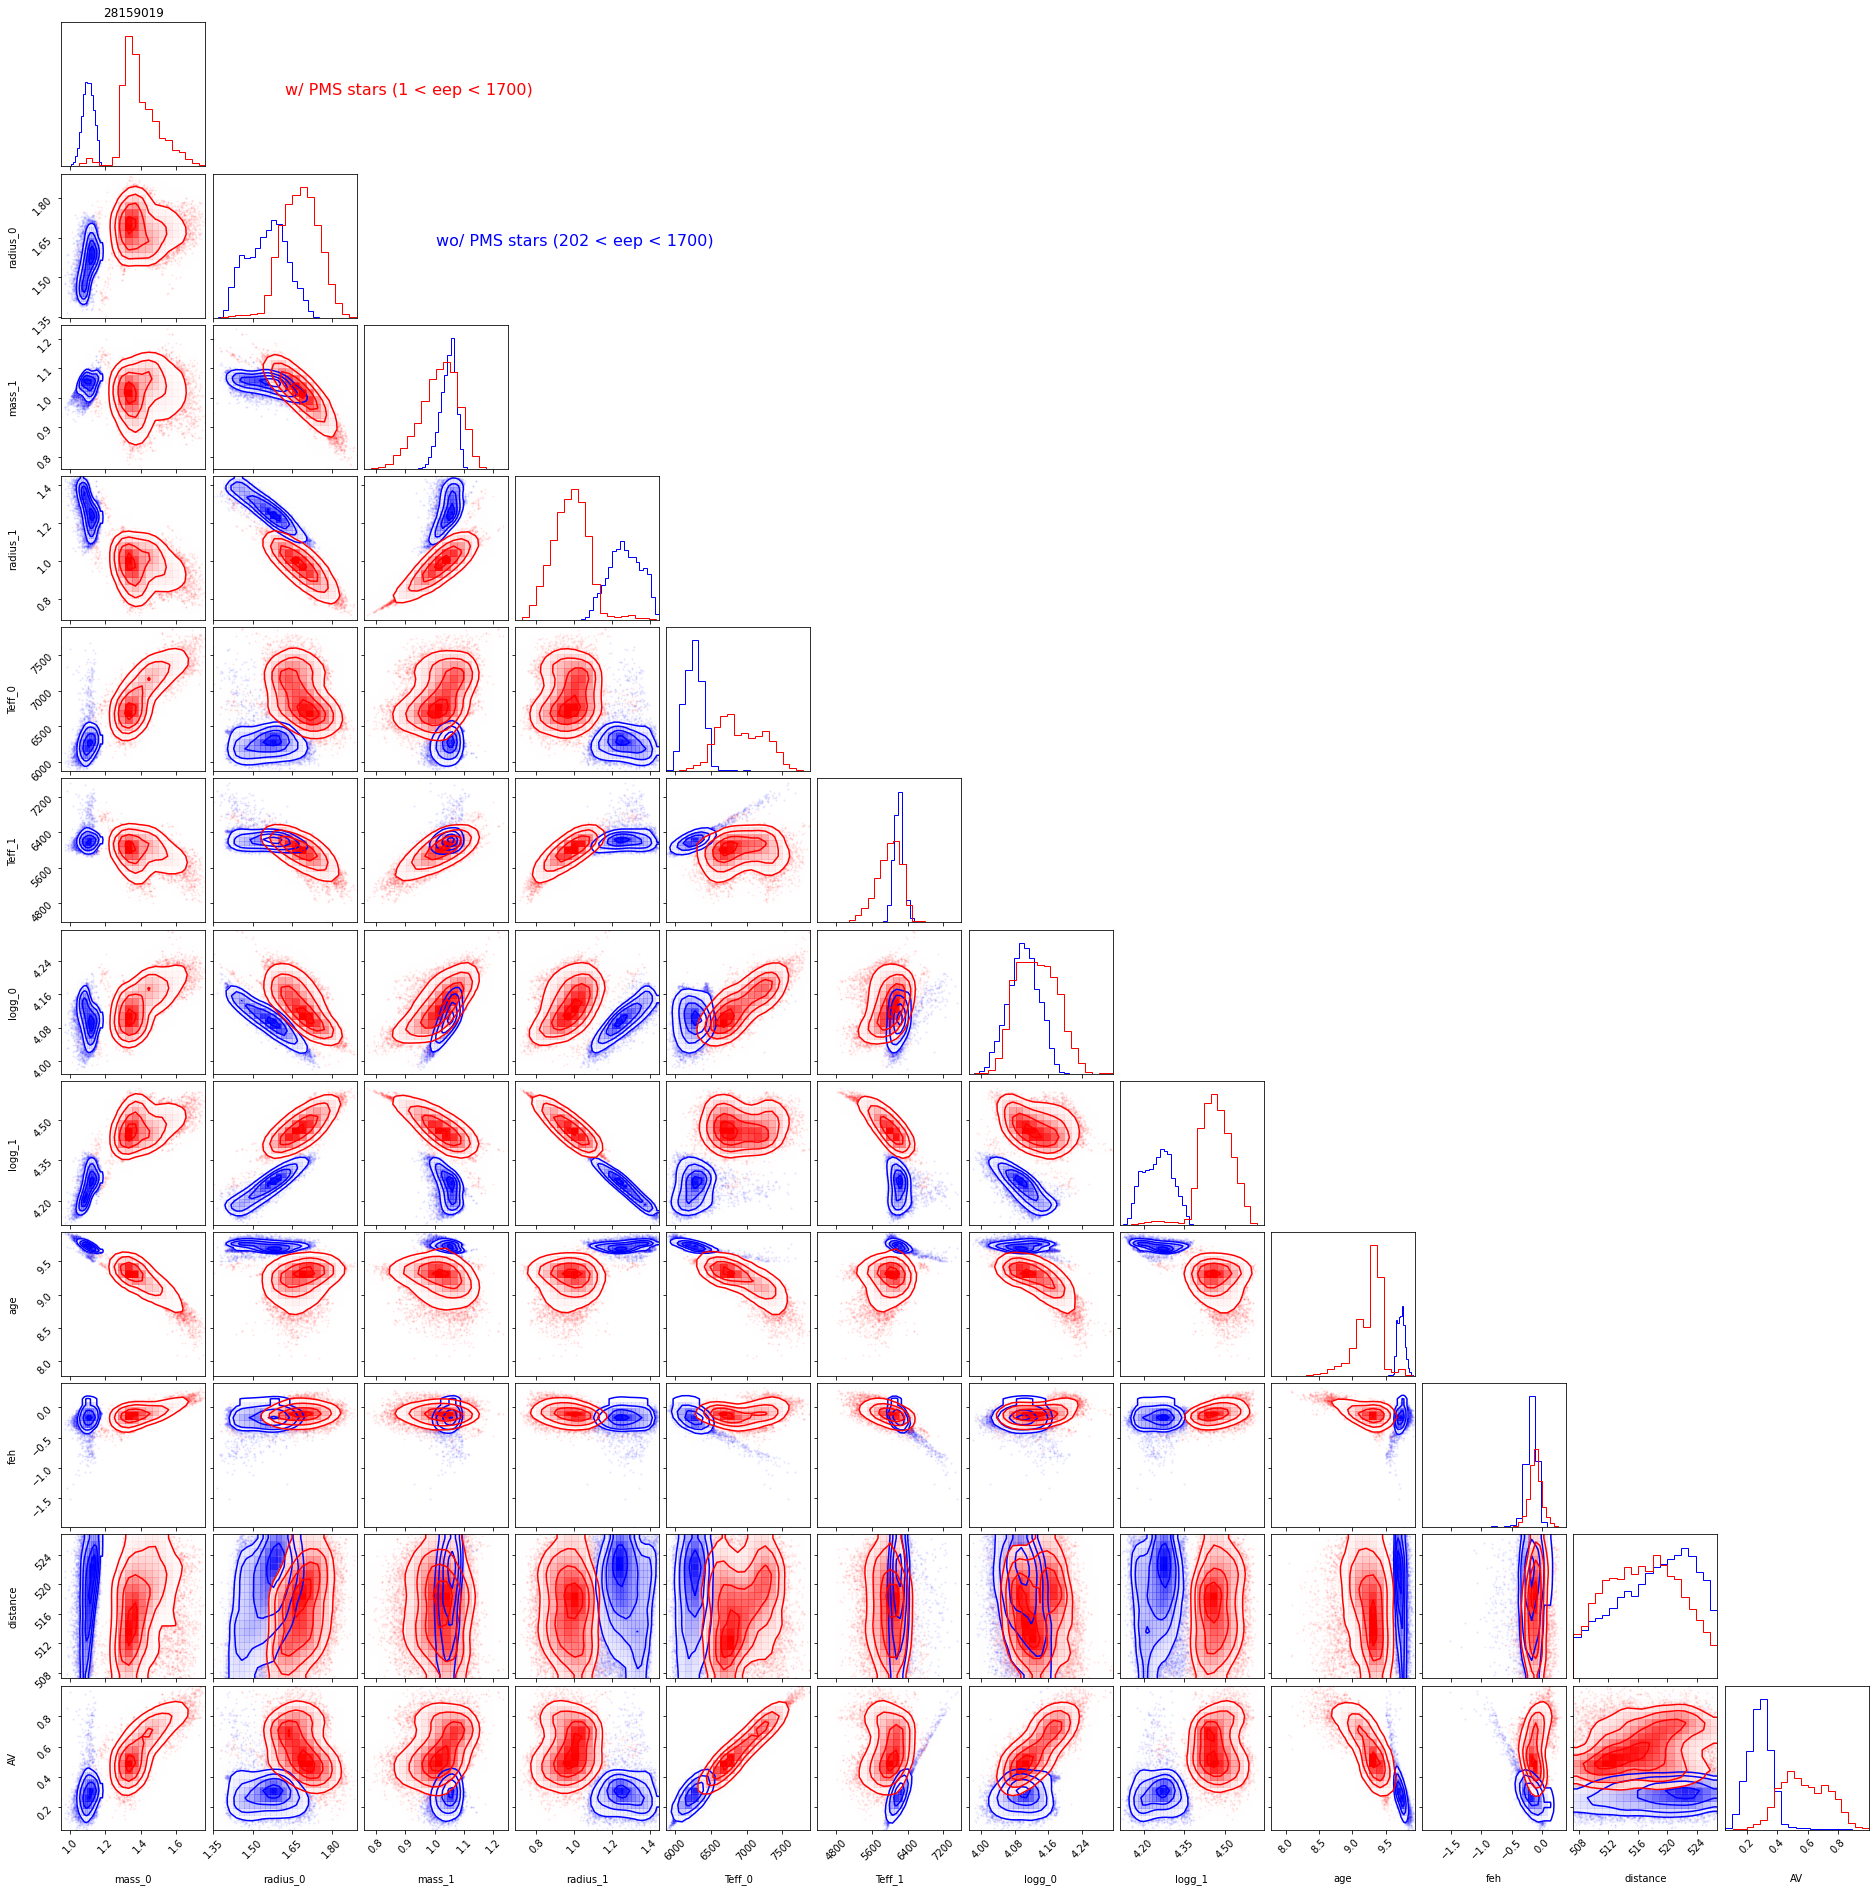

In [60]:
fig = corner(az.from_dict(
    binmod2.derived_samples[phys_quant].to_dict('list')),
    smooth=1, color='blue')
corner(az.from_dict(binmod.derived_samples[phys_quant].to_dict('list')),
       smooth=1, color='red', fig=fig)
fig.axes[0].set_title(str(tic_systems_of_interest[0]))
fig.axes[1].text(0.5,0.5,'w/ PMS stars (1 < eep < 1700)',color='red',fontsize=16)
fig.axes[14].text(0.5,0.5,'wo/ PMS stars (202 < eep < 1700)', color='blue', fontsize=16)
plt.savefig("isochrones_bin_model_corner_w_eep_lim.png",dpi=150)